# Import qbiome

In [1]:
import qbiome
from qbiome.data_formatter import DataFormatter
from qbiome.quantizer import Quantizer
from qbiome.qnet_orchestrator import QnetOrchestrator
from qbiome.mask_checker import MaskChecker
from qbiome.forecaster import Forecaster
from qbiome.hypothesis import Hypothesis

# Import other packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
plt.style.use('ggplot')

# Data

In [3]:
dirname = 'example_data/'
data = dirname + 'SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_TaxaRelativeAbundance.csv'
meta = dirname + 'SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_Characteristics.csv'

# Instantiate the data formatter, quantizer, qnet orchestrator

In [4]:
formatter = DataFormatter()
quantizer = Quantizer()
qnet_orchestrator = QnetOrchestrator(quantizer)

# Load, quantize, and convert the data to qnet input format

In [5]:
data = formatter.load_data(data, meta)
data_meta = formatter.load_meta(meta)
quantized = quantizer.quantize_df(data)
features, label_matrix = quantizer.get_qnet_inputs(quantized)

There are 29 unique biomes and 1216 unique samples
There are 311 unique days
There are 99 unique weeks


In [6]:
data

,sample_id,subject_id,variable,week,value
7,MBSMPL0020-6-10,1,Actinobacteriota,27,0.366650
8,MBSMPL0020-6-10,1,Bacteroidota,27,0.507248
9,MBSMPL0020-6-10,1,Campilobacterota,27,0.002032
10,MBSMPL0020-6-10,1,Desulfobacterota,27,0.005058
11,MBSMPL0020-6-10,1,Firmicutes,27,0.057767
...,...,...,...,...,...
6660,MBSMPL0020-6-998,16,Actinobacteriota,7,0.047280
6661,MBSMPL0020-6-998,16,Bacteroidota,7,0.452827
6662,MBSMPL0020-6-998,16,Campilobacterota,7,0.000377
6663,MBSMPL0020-6-998,16,Firmicutes,7,0.356165


In [7]:
data_meta

,sample_id,antibiotic,subject_id
0,MBSMPL0020-6-1,No,1
1,MBSMPL0020-6-10,Yes,1
2,MBSMPL0020-6-100,No,5
3,MBSMPL0020-6-101,No,5
4,MBSMPL0020-6-102,No,5
...,...,...,...
1211,MBSMPL0020-6-995,NaN,16
1212,MBSMPL0020-6-996,NaN,16
1213,MBSMPL0020-6-997,NaN,16
1214,MBSMPL0020-6-998,NaN,16


In [8]:
len(features)

622

# Train qnet

In [9]:
# should take < 5 min to run
qnet_orchestrator.train_qnet(
    features, label_matrix, alpha=0.2, min_samples_split=2, 
    out_fname='biome_net_test2.joblib')

# Use the mask checker to mask 20% of the label matrix and use qnet to predict

In [10]:
mask_checker = MaskChecker(qnet_orchestrator)

In [11]:
# takes 2 minutes to run
predicted = mask_checker.mask_and_predict(label_matrix, mask_percent=20)

In [12]:
predicted.head()

,subject_id,variable,week,value
0,1,Acidobacteriota,1,0.003810
1,10,Acidobacteriota,1,0.003873
2,11,Acidobacteriota,1,0.003652
3,12,Acidobacteriota,1,0.004157
4,14,Acidobacteriota,1,0.003589


# Plot the predicted vs. original biome measurements

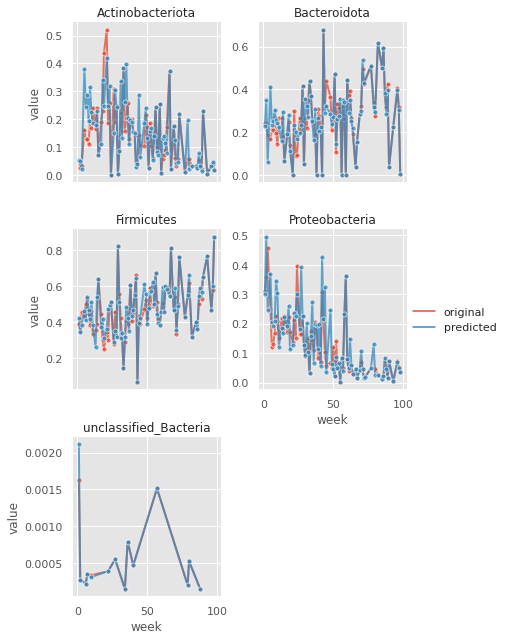

In [13]:
BIOMES = ['Actinobacteriota', 'Bacteroidota', 'Firmicutes', 'Proteobacteria', 'unclassified_Bacteria']

concat = pd.concat([
    data.assign(source='original'), 
    predicted.assign(source='predicted')
])
concat = concat[concat.variable.isin(BIOMES)]

g = sns.FacetGrid(concat, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', hue='source', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()

It appears that the prediction passes our eyeball sanity check.

We zoom in to look at the first 20 weeks.

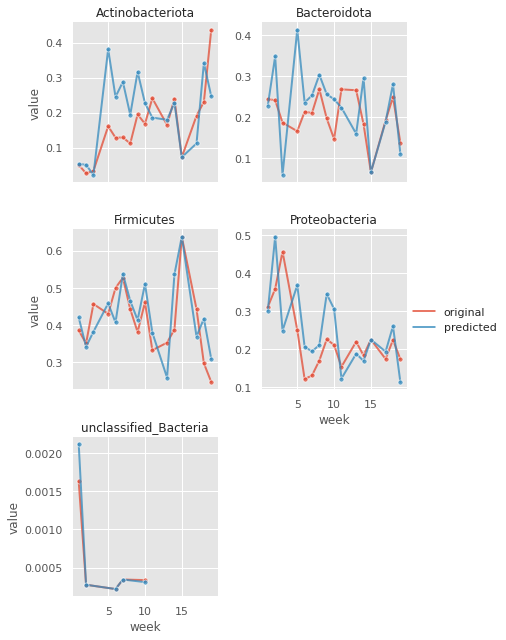

In [14]:
concat = concat[(concat.week <= 20)]

g = sns.FacetGrid(concat, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', hue='source', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()

To increase the precision of the prediction, we can apply the random forest regressor in the quantizer. See the example below when we use the forecaster.

# Use the forecaster to sequentially mask part of the original data and predict

In [15]:
forecaster = Forecaster(qnet_orchestrator)

In [16]:
# takes 10 minutes to run
# can specify an end week or default to the max end week in the data
forecasted = forecaster.forecast_data(
    label_matrix, 
    start_week=10,
#     end_week=data.week.max()
)

In [17]:
forecasted.head()

,subject_id,variable,week,value
0,1,Acidobacteriota,1,NaN
1,10,Acidobacteriota,1,NaN
2,11,Acidobacteriota,1,NaN
3,12,Acidobacteriota,1,NaN
4,14,Acidobacteriota,1,NaN


## Apply the random forest regressor in the quantizer

In [18]:
dequantized = quantizer.dequantize_to_df(label_matrix)
dequantized_plot = quantizer.melt_into_plot_format(dequantized)
quantizer.fit_random_forest(data, dequantized_plot)

In [19]:
avg_forecasted_regressed = quantizer.apply_random_forest_regressor(
    forecasted)

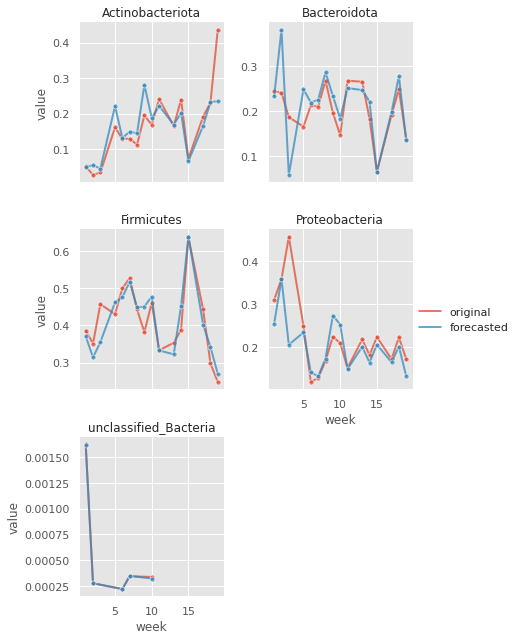

In [20]:
concat = pd.concat([
    data.assign(source='original'), 
    avg_forecasted_regressed.assign(source='forecasted')
])
concat = concat[concat.variable.isin(BIOMES)]
concat = concat[(concat.week <= 20)]

g = sns.FacetGrid(concat, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', hue='source', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()

# Construct a new subject using the quantizer and forecast

In [21]:
BIOMES = ['Actinobacteriota', 'Bacteroidota', 'Firmicutes', 'Proteobacteria', 'unclassified_Bacteria']

new_subject = pd.DataFrame({
    'week': [1] * len(BIOMES),
    'variable': BIOMES,
    'value': np.random.rand(len(BIOMES))
})

In [22]:
new_subject

,week,variable,value
0,1,Actinobacteriota,0.757276
1,1,Bacteroidota,0.825941
2,1,Firmicutes,0.720087
3,1,Proteobacteria,0.701021
4,1,unclassified_Bacteria,0.723903


In [23]:
new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id='101')

In [24]:
new_subject_quantized.head()

,subject_id,Acidobacteriota_1,Acidobacteriota_9,Acidobacteriota_27,Acidobacteriota_31,Acidobacteriota_35,Actinobacteriota_1,Actinobacteriota_2,Actinobacteriota_3,Actinobacteriota_5,...,unclassified_Bacteria_10,unclassified_Bacteria_22,unclassified_Bacteria_27,unclassified_Bacteria_34,unclassified_Bacteria_36,unclassified_Bacteria_40,unclassified_Bacteria_57,unclassified_Bacteria_79,unclassified_Bacteria_80,unclassified_Bacteria_88
0,101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# convert this new subject into a format acceptable by the qnet
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)

## Forecast the data starting from week 1 to the last week

In [28]:
# takes 2 minutes to run
new_subject_forecasted = forecaster.forecast_data(
    new_subject_matrix, 
    start_week=1
)

In [29]:
new_subject_forecasted.head()

,subject_id,variable,week,value
0,1,Acidobacteriota,1,0.003559
1,10,Acidobacteriota,1,NaN
2,11,Acidobacteriota,1,NaN
3,12,Acidobacteriota,1,NaN
4,14,Acidobacteriota,1,NaN


The NaNs are due to the random values we generated falling outside the quantization range.

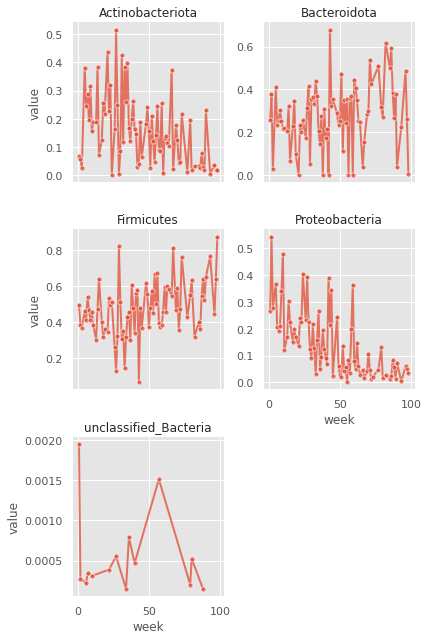

In [30]:
plottable = new_subject_forecasted[new_subject_forecasted.variable.isin(BIOMES)]

g = sns.FacetGrid(plottable, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()

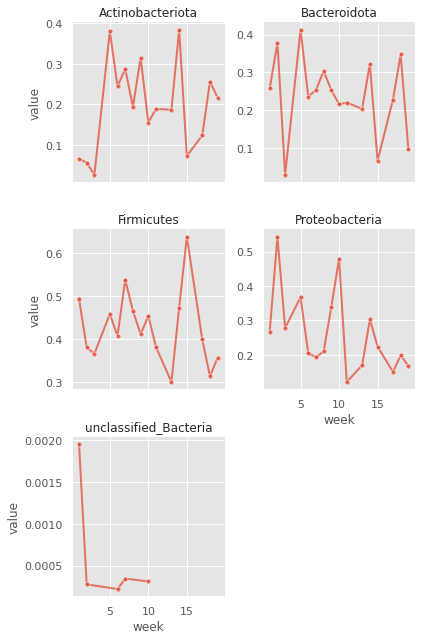

In [31]:
# zoom into the first 20 weeks
plottable = new_subject_forecasted[
    (new_subject_forecasted.variable.isin(BIOMES)) &
    (new_subject_forecasted.week <= 20)
     ]

g = sns.FacetGrid(plottable, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()